<a href="https://colab.research.google.com/github/vladiant/ObjectDetectSamples/blob/main/CustomModel/Model_Maker_Object_Detection_for_Airplane_Figurine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

Based on [Train a custom object detection model using your data](https://www.youtube.com/watch?v=-ZyFYniGUsw&list=WL&index=1&t=1s)

In [47]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect Android figurines and how to put the model on a Raspberry Pi.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [48]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

Import the required packages.

In [49]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [50]:
# !gdown --id ...
# !unzip -q CustomModelDataset.zip

In [51]:
!wget https://github.com/vladiant/ObjectDetectSamples/raw/main/CustomModel/CustomModelDataset.zip
!unzip -q CustomModelDataset.zip

--2022-02-17 06:38:53--  https://github.com/vladiant/ObjectDetectSamples/raw/main/CustomModel/CustomModelDataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/CustomModel/CustomModelDataset.zip [following]
--2022-02-17 06:38:53--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/CustomModel/CustomModelDataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8451592 (8.1M) [application/zip]
Saving to: ‘CustomModelDataset.zip.1’

CustomModelDataset. 100%[===================>]   8.06M  --.-KB/s    in 0.09s   

2022-02-17 06:38:53 (88.5 M

## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [52]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'CustomModelDataset/train',
    'CustomModelDataset/train',
    ['airplane']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'CustomModelDataset/validate',
    'CustomModelDataset/validate',
    ['airplane']
)

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [53]:
spec = model_spec.get('efficientdet_lite0')

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [54]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

Epoch 1/20
157/157 [==============================] - 83s 288ms/step - det_loss: 0.9790 - cls_loss: 0.5427 - box_loss: 0.0087 - reg_l2_loss: 0.0631 - loss: 1.0421 - learning_rate: 0.0065 - gradient_norm: 3.8914 - val_det_loss: 0.5763 - val_cls_loss: 0.3196 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0632 - val_loss: 0.6394
Epoch 2/20
157/157 [==============================] - 42s 269ms/step - det_loss: 0.6123 - cls_loss: 0.3349 - box_loss: 0.0055 - reg_l2_loss: 0.0632 - loss: 0.6756 - learning_rate: 0.0049 - gradient_norm: 3.7066 - val_det_loss: 0.4173 - val_cls_loss: 0.2204 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0633 - val_loss: 0.4806
Epoch 3/20
157/157 [==============================] - 42s 266ms/step - det_loss: 0.5623 - cls_loss: 0.3156 - box_loss: 0.0049 - reg_l2_loss: 0.0633 - loss: 0.6257 - learning_rate: 0.0048 - gradient_norm: 3.7593 - val_det_loss: 0.4497 - val_cls_loss: 0.2342 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0634 - val_loss: 0.5131
Epoch 4/20
157/157 [=====

### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the 10 images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [55]:
model.evaluate(val_data)

2/2 [==============================] - 13s 3s/step



{'AP': 0.53408074,
 'AP50': 0.9303331,
 'AP75': 0.56563866,
 'AP_/airplane': 0.53408074,
 'APl': 0.80561644,
 'APm': 0.62806773,
 'APs': 0.4079019,
 'ARl': 0.8375,
 'ARm': 0.71649486,
 'ARmax1': 0.21962617,
 'ARmax10': 0.5616822,
 'ARmax100': 0.6163551,
 'ARs': 0.51100916}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Raspberry Pi CPU and also compatible with the Google Coral EdgeTPU.

In [56]:
model.export(export_dir='.', tflite_filename='android.tflite')

### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [57]:
model.evaluate_tflite('android.tflite', val_data)

70/70 [==============================] - 183s 3s/step



{'AP': 0.53040963,
 'AP50': 0.9312574,
 'AP75': 0.54938895,
 'AP_/airplane': 0.53040963,
 'APl': 0.7919555,
 'APm': 0.62070733,
 'APs': 0.40543285,
 'ARl': 0.825,
 'ARm': 0.67938143,
 'ARmax1': 0.22102804,
 'ARmax10': 0.55280375,
 'ARmax100': 0.58785045,
 'ARs': 0.4889908}

Define some visualization functions
https://www.tensorflow.org/lite/tutorials/model_maker_object_detection

In [58]:
 !pip uninstall -y opencv-python-headless
 !pip install opencv-python-headless==4.1.2.30 

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [59]:
import cv2

from PIL import Image

In [60]:
# Load the labels into a list
classes = ['airplane'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

In [61]:
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

In [62]:
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image

In [63]:
def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

In [64]:
def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [65]:
INPUT_IMAGE_URL = "https://github.com/vladiant/ObjectDetectSamples/raw/main/CustomModel/42849.jpg"
DETECTION_THRESHOLD = 0.3

In [66]:
TEMP_FILE = 'image.jpg'

In [67]:
!wget -O $TEMP_FILE $INPUT_IMAGE_URL


--2022-02-17 07:07:56--  https://github.com/vladiant/ObjectDetectSamples/raw/main/CustomModel/42849.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/CustomModel/42849.jpg [following]
--2022-02-17 07:07:56--  https://raw.githubusercontent.com/vladiant/ObjectDetectSamples/main/CustomModel/42849.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15528 (15K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  15.16K  --.-KB/s    in 0s      

2022-02-17 07:07:56 (47.4 MB/s) - ‘image.jpg’ saved [15528/15528]



In [68]:
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

In [69]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='android.tflite')
interpreter.allocate_tensors()

In [70]:
# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

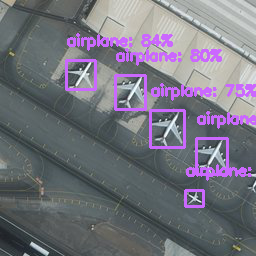

In [71]:
# Show the detection result
Image.fromarray(detection_result_image)